<a href="https://colab.research.google.com/github/geraldmc/torch-draft-final_project/blob/main/lr_sched_early_stop_pyt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color="red">First, please upload your kaggle.json file to the this notebook environment, as we will be using a Kaggle dataset. Visit [here](https://galhever.medium.com/how-to-import-data-from-kaggle-to-google-colab-8160caa11e2) to know how to upload. If you download the notebook to run on your own systems, then you should have the json file in `~/.kaggle` directory.</font>

# [Using Learning Rate Scheduler and Early Stopping with PyTorch](https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/)
![](https://debuggercafe.com/wp-content/uploads/2021/02/Using-Learning-Rate-Scheduler-and-Early-Stopping-with-PyTorch-1-e1613006792382.jpg)

## Setup and Dataset Download

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!mkdir input
!mkdir outputs
!mkdir src

In [ ]:
# download the dataset
!kaggle datasets download -d pmigdal/alien-vs-predator-images

 64% 9.00M/14.1M [00:00<00:00, 19.7MB/s]
100% 14.1M/14.1M [00:00<00:00, 31.9MB/s]


In [ ]:
!unzip /content/alien-vs-predator-images.zip -d input

Archive:  /content/alien-vs-predator-images.zip
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/0.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/1.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/10.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/100.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/101.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/102.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/103.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/104.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/105.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/106.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/107.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/train/alien/108.jpg  
  inflating: input/alien_vs_predator_thumbnails/data/trai

In [ ]:
%cd src

/content/src


## Prepare the Python Scripts

In [ ]:
%%writefile utils.py
import torch

class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor

        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor

        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )

    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


Writing utils.py


In [ ]:
%%writefile dataset.py
import torch
from torchvision import transforms, datasets

# define the image transforms and augmentations
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# traning and validation datasets and dataloaders
train_dataset = datasets.ImageFolder(
    root='../input/alien_vs_predator_thumbnails/data/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root='../input/alien_vs_predator_thumbnails/data/validation',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)


Writing dataset.py


In [ ]:
%%writefile models.py
import torch.nn as nn
import torchvision.models as models

def resnet50(pretrained=True, requires_grad=False):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # either freeze or train the hidden layer parameters
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model.fc = nn.Linear(2048, 2)
    return model


Writing models.py


In [ ]:
%%writefile train.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import time
import models
import argparse

from dataset import train_dataloader, val_dataloader
from dataset import train_dataset, val_dataset
from utils import EarlyStopping, LRScheduler
from tqdm import tqdm

matplotlib.style.use('ggplot')

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
args = vars(parser.parse_args())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
# instantiate the model
model = models.resnet50(pretrained=True, requires_grad=False).to(device)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# learning parameters 
lr = 0.001
epochs = 100
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

# strings to save the loss plot, accuracy plot, and model with different ...
# ... names according to the training type
# if not using `--lr-scheduler` or `--early-stopping`, then use simple names
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'model'

# either initialize early stopping or learning rate scheduler
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    # change the accuracy, loss plot names and model name
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    # change the accuracy, loss plot names and model name
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

# training function
def fit(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

# validation function
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

# lists to store per-epoch loss and accuracy values
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

print('Saving loss and accuracy plots...')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"../outputs/{acc_plot_name}.png")
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"../outputs/{loss_plot_name}.png")
plt.show()
    
# serialize the model to disk
print('Saving model...')
torch.save(model.state_dict(), f"../outputs/{model_name}.pth")
 
print('TRAINING COMPLETE')

Writing train.py


In [ ]:
!python train.py

Computation device: cuda

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:00<00:00, 160MB/s]
23,512,130 total parameters.
4,098 training parameters.
Epoch 1 of 100
Training
22it [00:03,  6.91it/s]
Validating
7it [00:00,  8.45it/s]           
Train Loss: 0.5206, Train Acc: 73.34
Val Loss: 0.3405, Val Acc: 85.50
Epoch 2 of 100
Training
22it [00:03,  7.23it/s]            
Validating
7it [00:00,  8.53it/s]           
Train Loss: 0.3250, Train Acc: 88.47
Val Loss: 0.2963, Val Acc: 84.50
Epoch 3 of 100
Training
22it [00:03,  7.18it/s]
Validating
7it [00:00,  8.55it/s]           
Train Loss: 0.2800, Train Acc: 89.05
Val Loss: 0.2442, Val Acc: 89.50
Epoch 4 of 100
Training
22it [00:03,  7.23it/s]
Validating
7it [00:00,  8.60it/s]           
Train Loss: 0.2231, Train Acc: 91.35
Val Loss: 0.2367, Val Acc: 89.50
Epoch 5 of 100
Training
22it [00:03,  7.26it/s]            
Validating
7it [00:00

In [ ]:
!python train.py --lr-scheduler

Computation device: cuda

23,512,130 total parameters.
4,098 training parameters.
INFO: Initializing learning rate scheduler
Epoch 1 of 100
Training
22it [00:03,  6.97it/s]
Validating
7it [00:00,  8.46it/s]           
Train Loss: 0.5942, Train Acc: 66.14
Val Loss: 0.4076, Val Acc: 80.50
Epoch 2 of 100
Training
22it [00:03,  7.21it/s]
Validating
7it [00:00,  8.45it/s]           
Train Loss: 0.4126, Train Acc: 81.27
Val Loss: 0.3312, Val Acc: 89.50
Epoch 3 of 100
Training
22it [00:03,  7.16it/s]
Validating
7it [00:00,  8.48it/s]           
Train Loss: 0.3017, Train Acc: 89.05
Val Loss: 0.2570, Val Acc: 89.50
Epoch 4 of 100
Training
22it [00:03,  7.08it/s]
Validating
7it [00:00,  8.41it/s]           
Train Loss: 0.2383, Train Acc: 92.22
Val Loss: 0.2393, Val Acc: 89.50
Epoch 5 of 100
Training
22it [00:03,  7.14it/s]
Validating
7it [00:00,  8.46it/s]           
Train Loss: 0.2355, Train Acc: 90.92
Val Loss: 0.2258, Val Acc: 88.00
Epoch 6 of 100
Training
22it [00:03,  7.18it/s]
Validating
7

In [ ]:
!python train.py --early-stopping

Computation device: cuda

23,512,130 total parameters.
4,098 training parameters.
INFO: Initializing early stopping
Epoch 1 of 100
Training
22it [00:03,  6.74it/s]
Validating
7it [00:00,  8.44it/s]           
Train Loss: 0.5923, Train Acc: 69.31
Val Loss: 0.3991, Val Acc: 88.00
Epoch 2 of 100
Training
22it [00:03,  7.15it/s]            
Validating
7it [00:00,  8.43it/s]           
Train Loss: 0.3331, Train Acc: 90.63
Val Loss: 0.3033, Val Acc: 88.50
Epoch 3 of 100
Training
22it [00:03,  7.13it/s]
Validating
7it [00:00,  8.33it/s]           
Train Loss: 0.2767, Train Acc: 91.07
Val Loss: 0.2739, Val Acc: 86.00
Epoch 4 of 100
Training
22it [00:03,  7.12it/s]
Validating
7it [00:00,  8.44it/s]           
INFO: Early stopping counter 1 of 5
Train Loss: 0.2769, Train Acc: 89.34
Val Loss: 0.3182, Val Acc: 85.50
Epoch 5 of 100
Training
22it [00:03,  7.16it/s]            
Validating
7it [00:00,  8.33it/s]           
Train Loss: 0.2605, Train Acc: 89.34
Val Loss: 0.2447, Val Acc: 88.50
Epoch 6 o

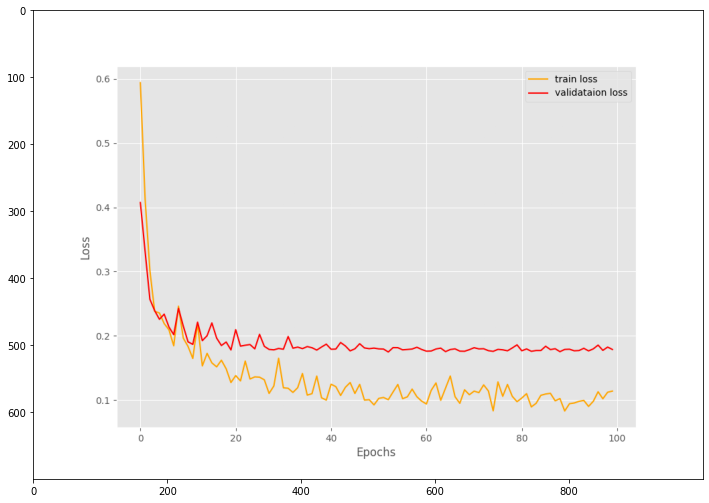

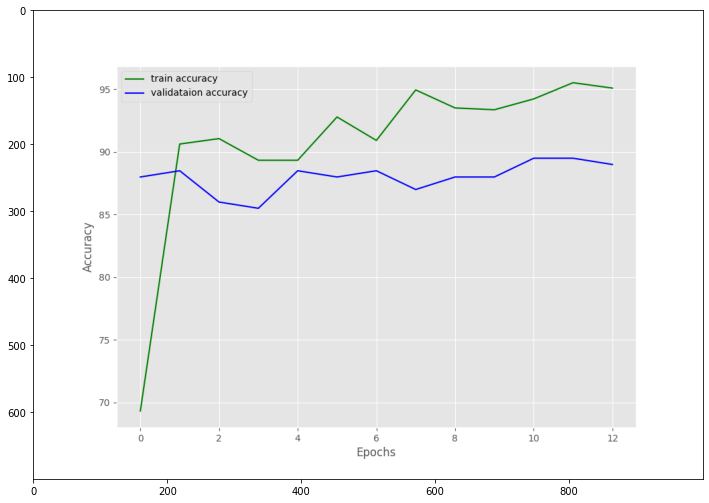

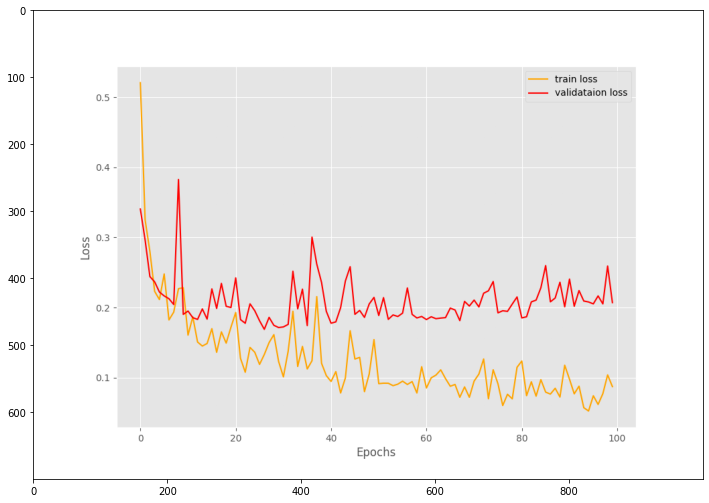

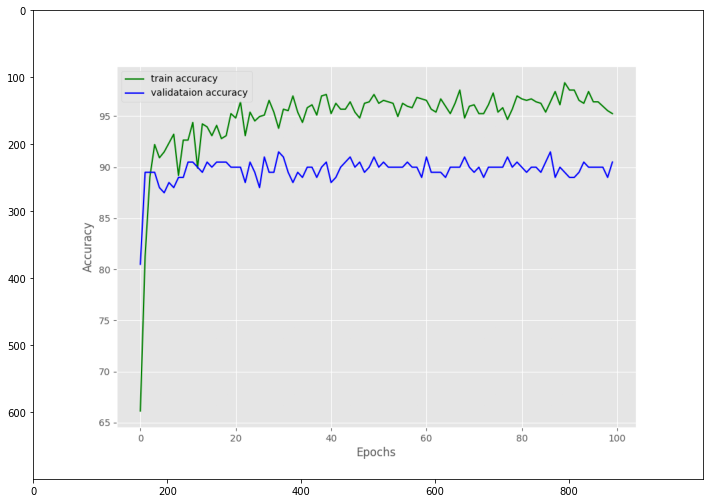

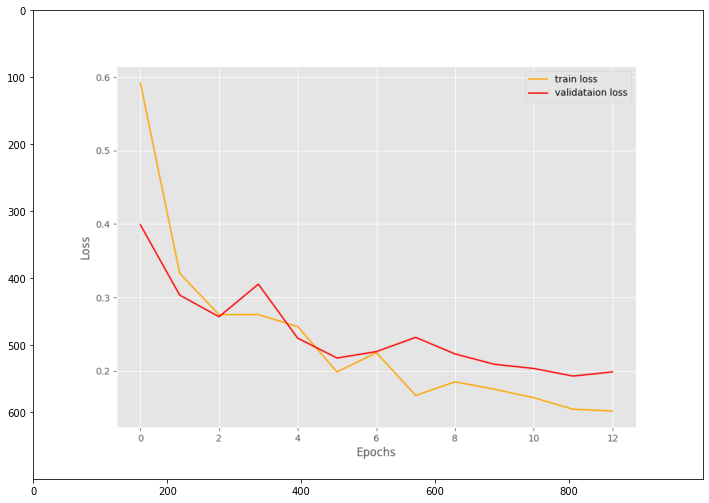

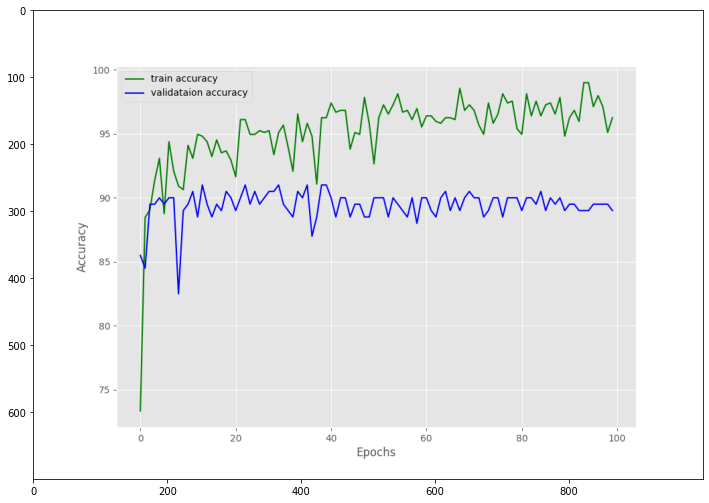

In [ ]:
import glob as glob
import matplotlib.pyplot as plt

plots = glob.glob('../outputs/*.png')
for plot in plots:
    image = plt.imread(plot)
    plt.figure(figsize=(12, 9))
    plt.imshow(image)
    plt.show()